# Tropics Temperature Quantile Theory
Looks at how Theory 4 does at predicted quantiles of temperature extremes in the tropics

In [124]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
pressure_ft = 500                             # only keep surface and free troposphere pressure values
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f'k={tau_lw_ref}', f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]
p_surface = float(ds[0].pfull[-1]) * 100              # pressure where surface temperature is computed - same for all ds, in Pa.
pressure_ft_actual = float(ds[0].pfull[0]) * 100      # actual ft pressure saved in dataset in Pa

Experiment 0: Evap param not specified so set to default value of 1
Experiment 1: Evap param not specified so set to default value of 1


## Get datasets
Get one dataset, `ds_quant`, for ocean, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the ocean summer for a given latitude bin.

In [3]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 30
# lat_max = 60

ds_summer = []
ds_all = {'ocean': []}

with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        ds_all['ocean'] += [ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))]
        ds_all['ocean'][i].load()

        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))    # NH summer is JAS
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is JFM
        # Combine hemispheres and average over longitude, time and latitude.
        # Note that April, May, June, October, November and December will not be included in this dataset
        ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        ds_summer += [ds_use]
        ds_summer[i].load()
        pbar.update(1)

100%|██████████| 2/2 [00:29<00:00, 14.55s/it]


## Temperature Percentile
Recreating Figure 2 of Byrne 2021.

In [5]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp[-1].quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp[-1] > quantile_thresh)[0]
    return quant_ind

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

surfaces = ['ocean', 'ocean_summer']
n_surf = len(surfaces)
quant_plot = np.arange(100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)

# surface values
temp_quant = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
sphum_quant = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
z_quant = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
mse = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}

# free troposphere values
temp_quant_ft = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
sphum_quant_ft = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
z_quant_ft = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
mse_ft_sat = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}

with tqdm(total=n_exp*n_quant*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            for k, ds_use in enumerate([ds_all['ocean'], ds_summer]):
                use_ind = get_quant_ind(ds_use[i], quant)
                temp_quant[surfaces[k]][i, j] = np.mean(ds_use[i].temp[-1][use_ind])
                sphum_quant[surfaces[k]][i, j] = np.mean(ds_use[i].sphum[-1][use_ind])
                z_quant[surfaces[k]][i, j] = np.mean(ds_use[i].height[-1][use_ind])
                mse[surfaces[k]][i, j] = np.mean(moist_static_energy(ds_use[i].temp[-1][use_ind], ds_use[i].sphum[-1][use_ind],
                                                                     ds_use[i].height[-1][use_ind]))

                temp_quant_ft[surfaces[k]][i, j] = np.mean(ds_use[i].temp[0][use_ind])
                sphum_quant_ft[surfaces[k]][i, j] = np.mean(ds_use[i].sphum[0][use_ind])
                z_quant_ft[surfaces[k]][i, j] = np.mean(ds_use[i].height[0][use_ind])
                mse_ft_sat[surfaces[k]][i, j] = np.mean(moist_static_energy(ds_use[i].temp[0][use_ind],
                                                                            sphum_sat(ds_use[i].temp[0][use_ind], pressure_ft_actual),
                                                                            ds_use[i].height[0][use_ind]))
                pbar.update(1)

temp_mean = {surf: np.asarray([temp_quant[surf][i][0] for i in range(n_exp)]) for surf in surfaces}

100%|██████████| 400/400 [01:15<00:00,  5.30it/s]


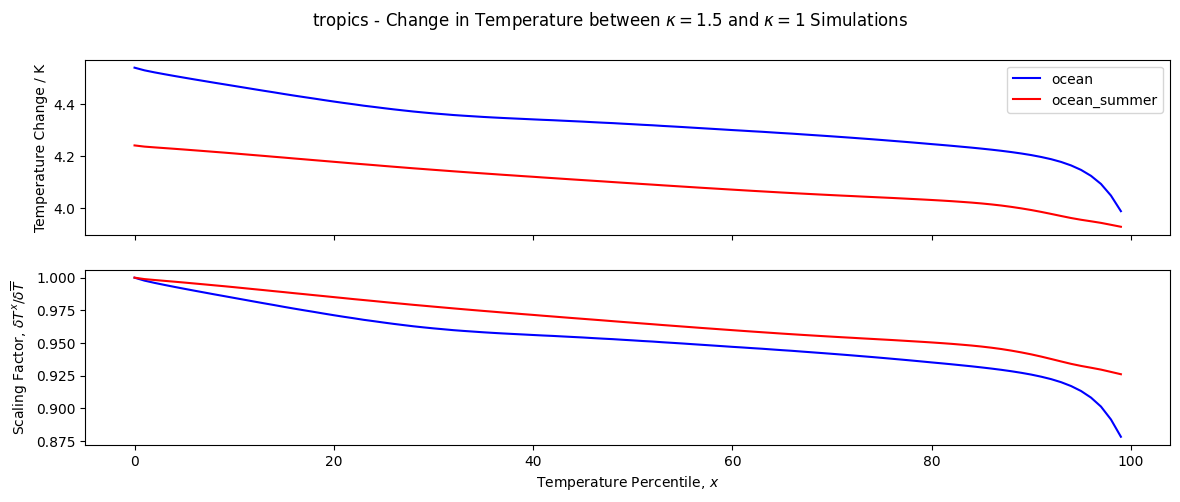

In [6]:
# Plot temperature change vs percentile
plt_color = {'ocean_summer': 'red', 'ocean': 'blue'}
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
for surf in surfaces:
    temp_diff_quant = temp_quant[surf][1]-temp_quant[surf][0]
    temp_diff_mean = temp_mean[surf][1]-temp_mean[surf][0]
    ax[0].plot(quant_plot, temp_diff_quant, label=surf, color=plt_color[surf])
    ax[1].plot(quant_plot, temp_diff_quant/temp_diff_mean, label=surf, color=plt_color[surf])
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Moist Static Energy
The assumption of quasi convective equilibrium says that $\delta h_x = \delta \overline{h}$ i.e. the change in MSE on the $x$ percentile temperature day is equal to that on the mean, $x=0$, day. This is saying that both the mean and $x$ percentile day can differ from convective neutral profile but that this difference remains constant as the climate warms.

The bottom left plot below indicate that for the hottest days over ocean, $\delta h_x$ is significantly larger than $\delta \overline{h}$, indicating that this may break down.

The right plots show that in the free troposphere, over ocean, the MSE decreases for the highest surface temperature percentiles. The free troposphere saturated MSE only depends on free troposphere temperature, so this indicates that the free troposphere temperature does not increase in relation to the surface temperature as we may expect. This then means that the temperature profile must differ as $x$ changes.

Note, that computing the mean MSE from the mean temperature, specific humidity and height is not quite the same as taking the average of all individual MSE values but it is very similar - they are the same to much less than 0.1%.

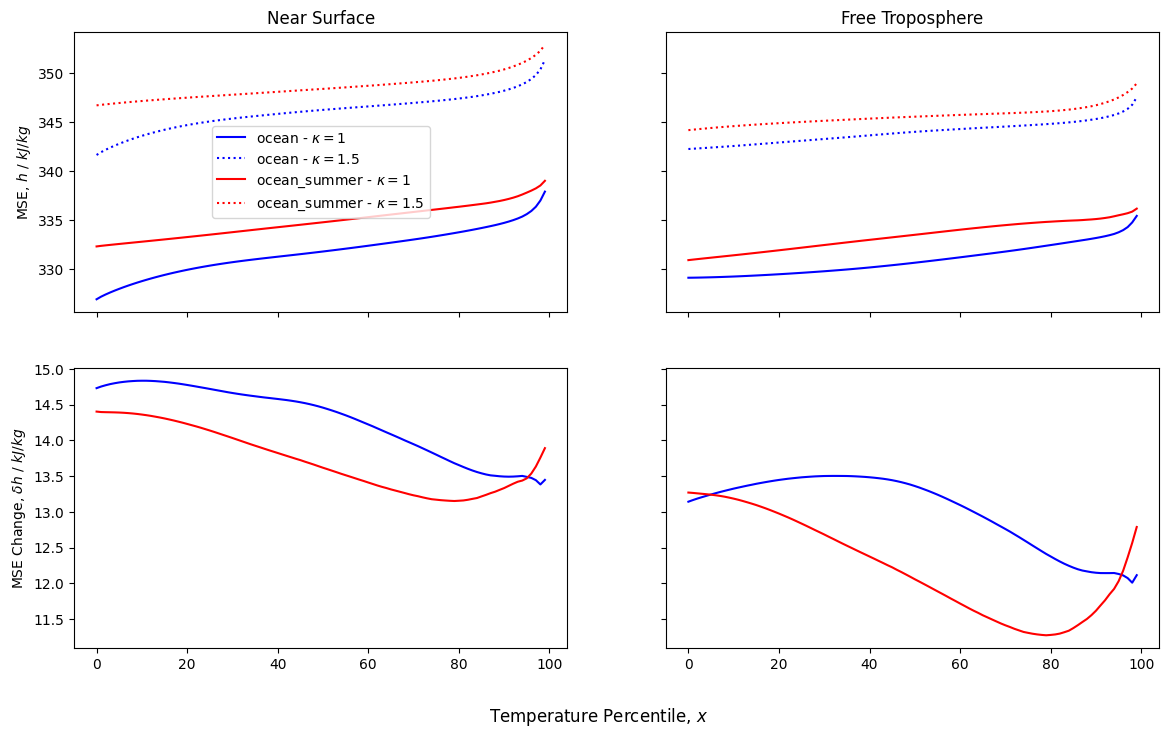

In [11]:
fig, ax = plt.subplots(2,2, figsize=(14, 8), sharex=True, sharey='row')
for surf in surfaces:
    ax[0,0].plot(quant_plot, mse[surf][0], color=plt_color[surf], label=f'{surf} - $\kappa={tau_lw_ref}$')
    ax[0,0].plot(quant_plot, mse[surf][1], color=plt_color[surf], linestyle=':', label=f'{surf} - $\kappa={tau_lw_warm}$')
    ax[0,1].plot(quant_plot, mse_ft_sat[surf][0], color=plt_color[surf], label=surf)
    ax[0,1].plot(quant_plot, mse_ft_sat[surf][1], color=plt_color[surf], label=surf, linestyle=':')

    ax[1,0].plot(quant_plot, mse[surf][1] - mse[surf][0], color=plt_color[surf])
    ax[1,1].plot(quant_plot, mse_ft_sat[surf][1] - mse_ft_sat[surf][0], color=plt_color[surf])
#ax.plot(quant_plot, mse['ocean'][1]-mse['ocean'][0], color='blue', label='Simulated $\delta h_x$')
# ax.plot(lat_centre, mse_quant_diff_sim, color='k', linestyle='--', label='Theory $\delta h_x$')
# ax.plot(lat_centre, mse_summer_diff, color='r', linestyle=':', label='Mean, $\delta \overline{h}$')
fig.supxlabel('Temperature Percentile, $x$')
ax[0,0].set_ylabel(f'MSE, $h$ / $kJ/kg$')
ax[0,0].set_title(f'Near Surface')
ax[0,1].set_title(f'Free Troposphere')
ax[1,0].set_ylabel(f'MSE Change, $\delta h$ / $kJ/kg$')
ax[0,0].legend();

Another theory is that $\delta h_x = \delta \overline{h} + \delta \Delta h^*_{x,FT}$. This is saying that as the climate warms, both the mean and $x$ percentile day, can vary their difference from convective neutrality by an amount $\delta \epsilon$ but that this amount must be the same for the mean and $x$ percentile day.

The plots below investigate this theory (4) and the quasi convective neutrality theory (3).

If we take the mean day to be that over ocean (bottom left plot), then we see that theory 4 captures the broad trend of $\delta h$ with $x$ over land and matches it especially well at large $x$.

Over ocean, we see that theory 4 predicts the complete opposite trend with $x$ at large $x$.

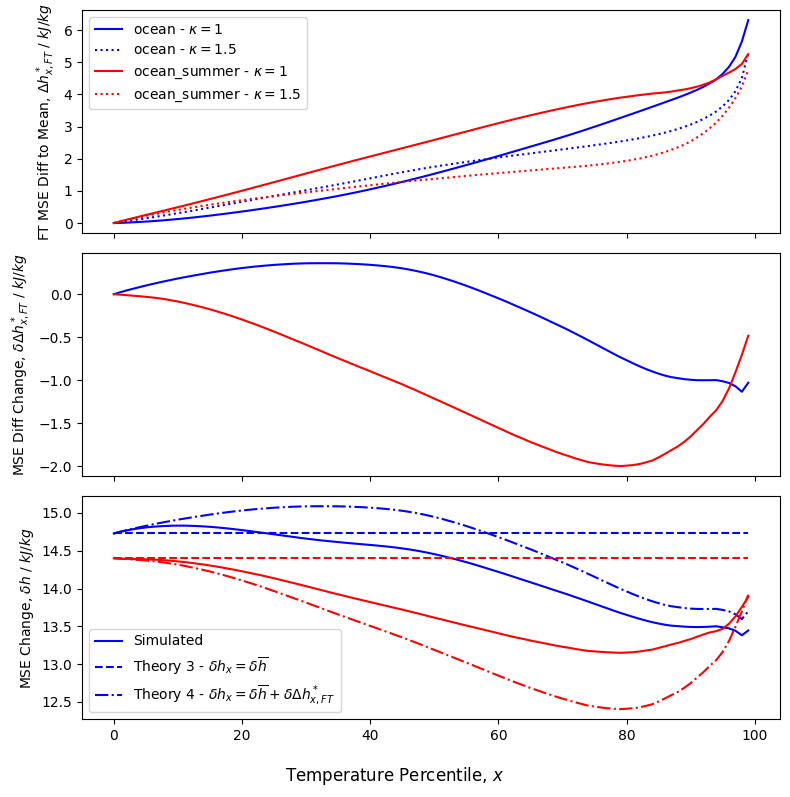

In [23]:
mse_ft_diff2 = {}        # uses relavent surface as mean
fig, ax = plt.subplots(3,1, figsize=(8, 8), sharex=True, sharey='row')
for surf in surfaces:
    mse_ft_diff2[surf] = np.asarray([mse_ft_sat[surf][i]-mse_ft_sat[surf][i][0] for i in range(n_exp)])
    ax[0].plot(quant_plot, mse_ft_diff2[surf][0], color=plt_color[surf], label=f'{surf} - $\kappa={tau_lw_ref}$')
    ax[0].plot(quant_plot, mse_ft_diff2[surf][1], color=plt_color[surf],
                 linestyle=':', label=f'{surf} - $\kappa={tau_lw_warm}$')

    ax[1].plot(quant_plot, mse_ft_diff2[surf][1] - mse_ft_diff2[surf][0], color=plt_color[surf])

    if surf == 'ocean':
        label0 = 'Simulated'
        label1 = 'Theory 3 - $\delta h_x = \delta \overline{h}$'
        label2 = 'Theory 4 - $\delta h_x = \delta \overline{h} + \delta \Delta h^*_{x,FT}$'
    else:
        label0 = None
        label1 = None
        label2 = None
    ax[2].plot(quant_plot,  mse[surf][1] - mse[surf][0], color=plt_color[surf], label=label0)
    ax[2].plot(quant_plot, (mse[surf][1] - mse[surf][0])[0] * np.ones_like(quant_plot), color=plt_color[surf], linestyle='--',
               label=label1)
    ax[2].plot(quant_plot, (mse[surf][1] - mse[surf][0])[0] + mse_ft_diff2[surf][1] - mse_ft_diff2[surf][0],
                 color=plt_color[surf], linestyle='-.', label=label2)
#ax.plot(quant_plot, mse['ocean'][1]-mse['ocean'][0], color='blue', label='Simulated $\delta h_x$')
# ax.plot(lat_centre, mse_quant_diff_sim, color='k', linestyle='--', label='Theory $\delta h_x$')
# ax.plot(lat_centre, mse_summer_diff, color='r', linestyle=':', label='Mean, $\delta \overline{h}$')
fig.supxlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('FT MSE Diff to Mean, $\Delta h^*_{x,FT}$ / $kJ/kg$')
ax[1].set_ylabel('MSE Diff Change, $\delta \Delta h^*_{x,FT}$ / $kJ/kg$')
ax[2].set_ylabel(f'MSE Change, $\delta h$ / $kJ/kg$')
ax[0].legend()
ax[2].legend()
plt.tight_layout();

In [25]:
def get_temp_theory_gamma(temp_x, sphum_x, delta_rh_x, temp_mean, sphum_mean, delta_rh_mean):
    # All input variables are at the lower reference kappa simulation
    # Outputs factors used in the theoretical predictions for changes in temperature
    denom = c_p + L_v * clausius_clapeyron_factor(temp_x) * (sphum_x + sphum_sat(temp_x, p_surface) * delta_rh_x)
    gamma_t = c_p + L_v * clausius_clapeyron_factor(temp_mean) * (sphum_mean + sphum_sat(temp_mean, p_surface) * delta_rh_mean)
    gamma_t = gamma_t / denom
    gamma_r_mean = L_v * sphum_sat(temp_mean, p_surface) / denom
    gamma_r_quant = -L_v * sphum_sat(temp_x, p_surface) / denom
    gamma_z_diff = g / denom
    gamma_mse_diff = 1/denom
    return gamma_t, gamma_r_mean, gamma_r_quant, gamma_z_diff, gamma_mse_diff

rh_quant = {surf: np.asarray([rh_from_sphum(sphum_quant[surf][i],temp_quant[surf][i],p_surface)/100 for i in range(n_exp)])
            for surf in surfaces}
rh_mean = {surf: np.asarray([rh_from_sphum(sphum_quant[surf][i][0],temp_quant[surf][i][0],p_surface)/100 for i in range(n_exp)])
           for surf in surfaces}


# Version to use with mse_ft_diff2 as always uses relevant surface as mean
gamma = {surf: get_temp_theory_gamma(temp_quant[surf][0], sphum_quant[surf][0], rh_quant[surf][1] - rh_quant[surf][0],
                                     temp_mean[surf][0], sphum_quant[surf][0][0], rh_mean[surf][1] - rh_mean[surf][0])
         for surf in surfaces}


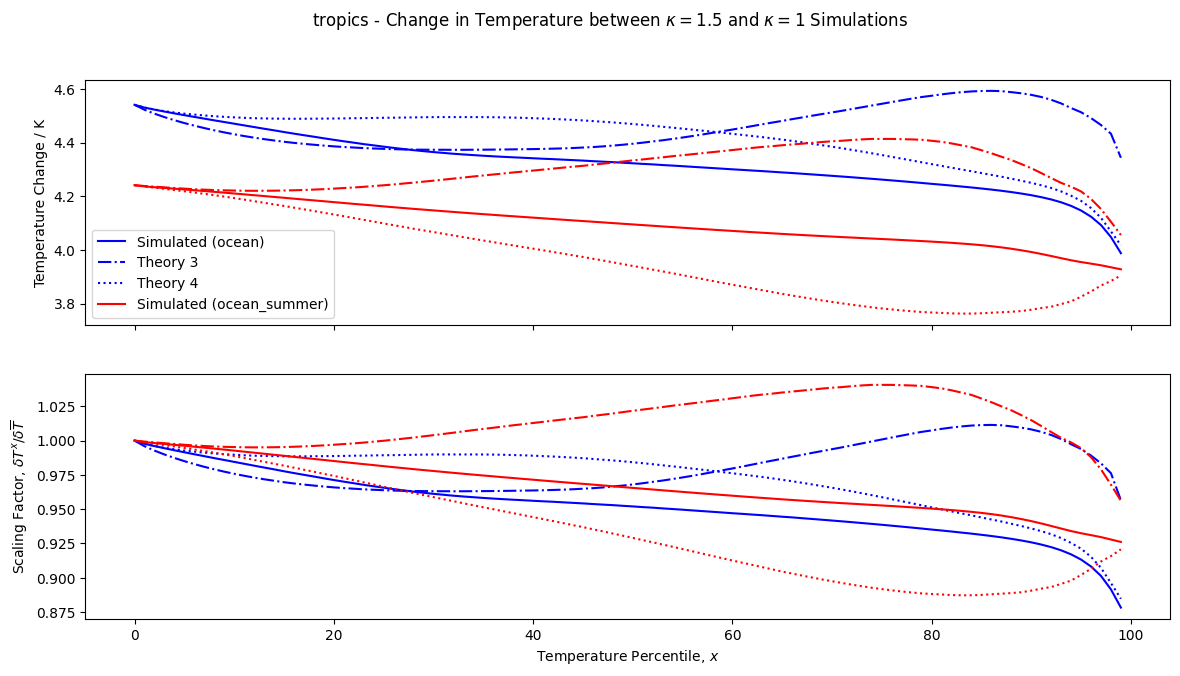

In [392]:
# Need to multiply MSE contribution by 1000 to put MSE in units of J/kg rather than kJ/kg
# For mean, use 'ocean' because always consider the ocean mean the mean value
# Leave out tiny Delta Z contribution
temp_theory_cont = {surf: np.asarray([gamma[surf][0] * (temp_mean[surf][1] - temp_mean[surf][0]),
                                      gamma[surf][1] * (rh_mean[surf][1] - rh_mean[surf][0]),
                                      gamma[surf][2] * (rh_quant[surf][1] - rh_quant[surf][0]),
                                      gamma[surf][4] * 1000 * (mse_ft_diff2[surf][1] - mse_ft_diff2[surf][0])])
                    for surf in surfaces}
temp_cont_labels = ['$\delta \overline{T}$', '$\delta \overline{r}$', '$\delta r_x$', '$\delta \Delta h^*_{x,FT}$']

fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True)
for surf in surfaces:
    temp_diff_quant = temp_quant[surf][1]-temp_quant[surf][0]
    temp_diff_mean = temp_mean[surf][1]-temp_mean[surf][0]
    ax[0].plot(quant_plot, temp_diff_quant, label=f'Simulated ({surf})', color=plt_color[surf])
    if surf == 'ocean':
        label1 = 'Theory 3'
        label2 = 'Theory 4'
    else:
        label1 = None
        label2 = None
    ax[0].plot(quant_plot, np.sum(temp_theory_cont[surf][:3], axis=0), label=label1, color=plt_color[surf], linestyle='-.')
    ax[0].plot(quant_plot, np.sum(temp_theory_cont[surf][:4], axis=0), label=label2, color=plt_color[surf], linestyle=':')
    ax[1].plot(quant_plot, temp_diff_quant/temp_diff_mean, label=f'Simulated ({surf})', color=plt_color[surf])
    ax[1].plot(quant_plot, np.sum(temp_theory_cont[surf][:3], axis=0)/np.sum(temp_theory_cont[surf][:3], axis=0)[0],
               label=surf, color=plt_color[surf], linestyle='-.')
    ax[1].plot(quant_plot, np.sum(temp_theory_cont[surf][:4], axis=0)/np.sum(temp_theory_cont[surf][:4], axis=0)[0], label=surf, color=plt_color[surf], linestyle=':')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

### Theory Temperature Contributions
The plots below show that for land, there is a much larger contribution to the theory from change in relative humidity than for ocean.

Also the $\gamma^T$ decreases for the largest $x$ which is the opposite of what is shown in byrne 2021.


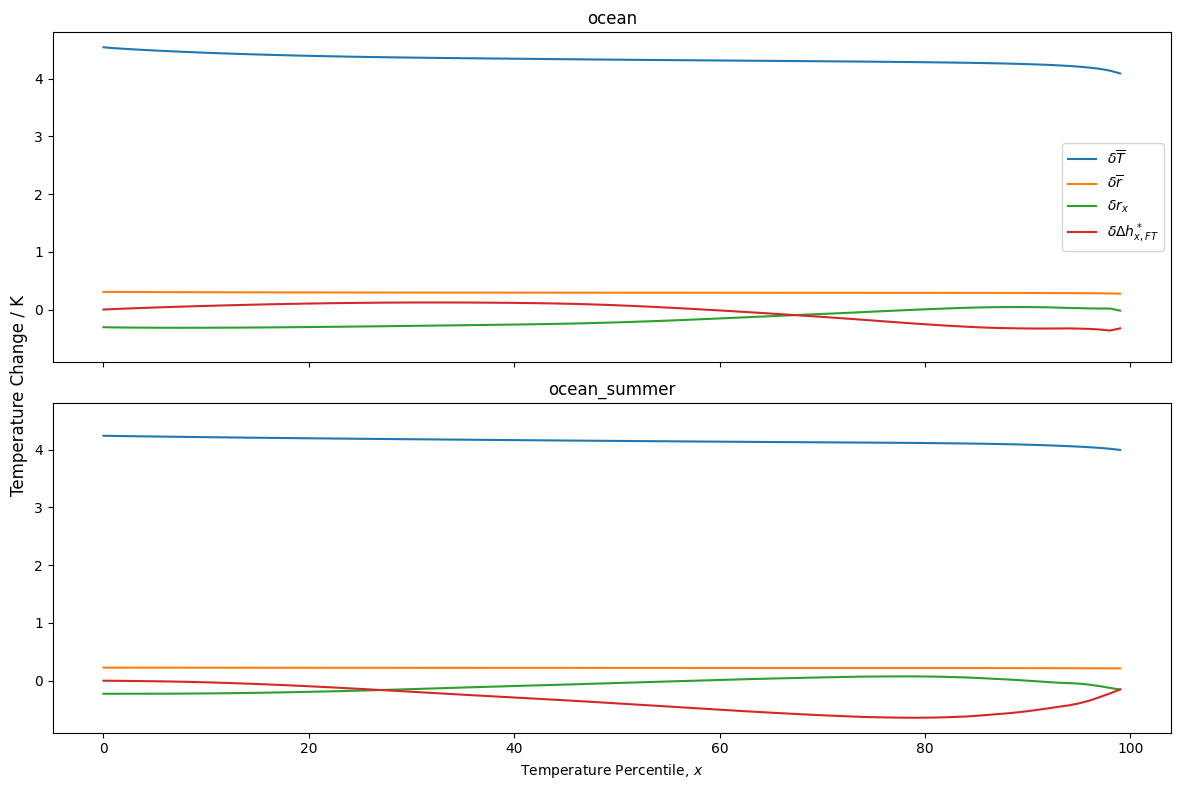

In [32]:
fig, ax = plt.subplots(n_surf,1, figsize=(12, 8), sharex=True, sharey=True)
for k, surf in enumerate(surfaces):
    for i in range(len(temp_theory_cont[surf])):
        ax[k].plot(quant_plot, temp_theory_cont[surf][i], label=temp_cont_labels[i])
        ax[k].set_title(surf)
ax[0].legend()
ax[1].set_xlabel('Temperature Percentile, $x$')
fig.supylabel('Temperature Change / K')
plt.tight_layout();

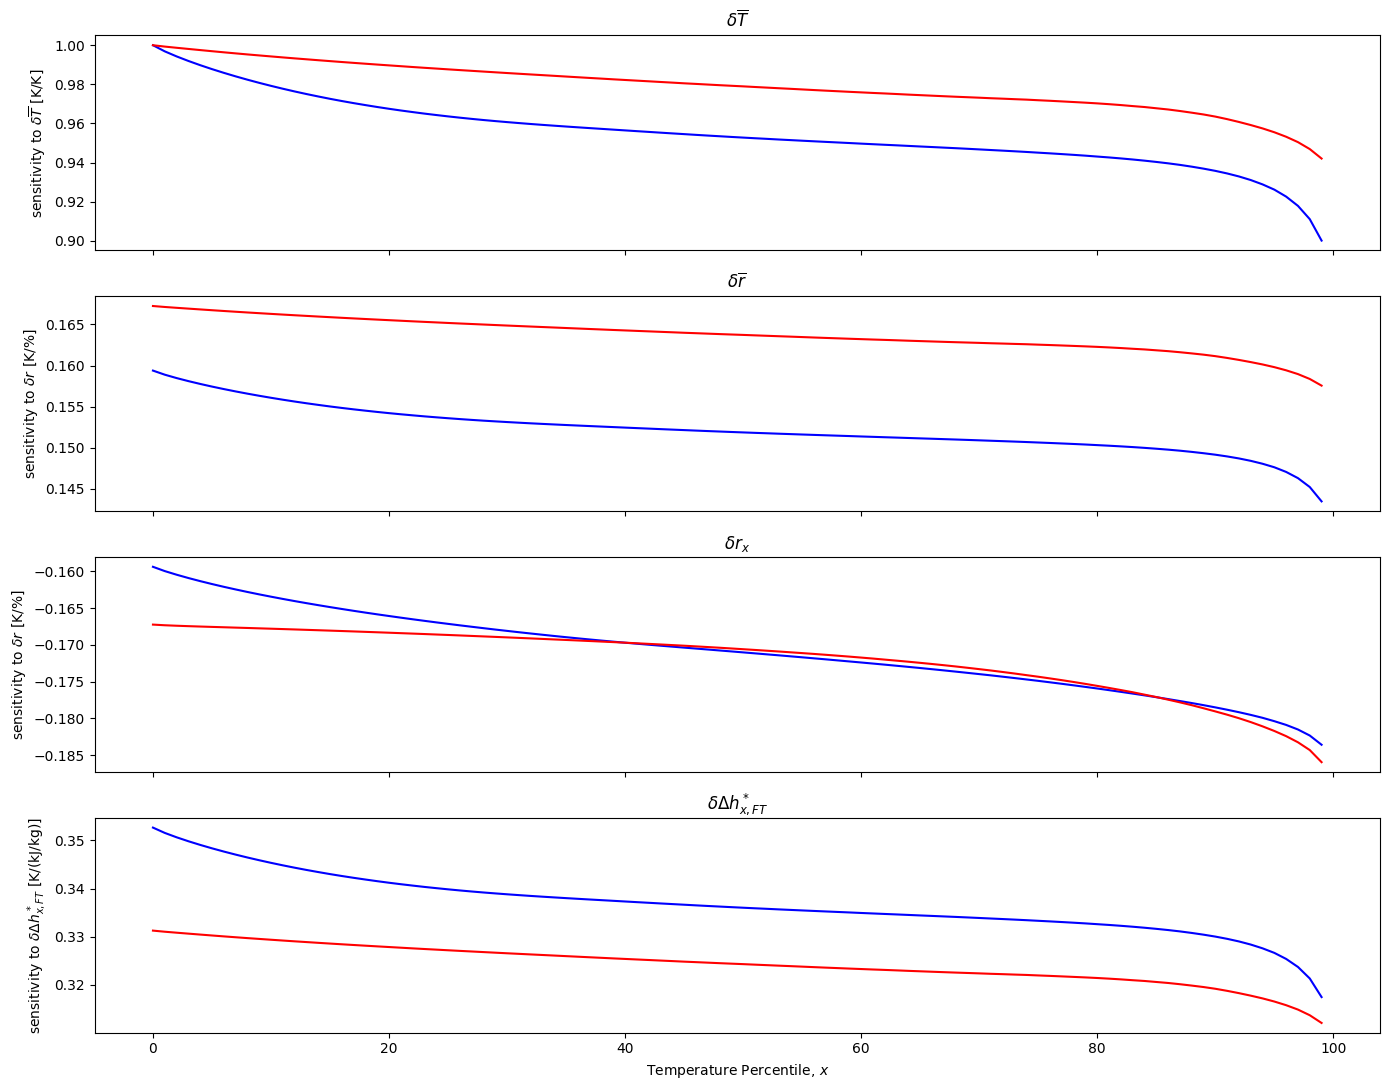

In [33]:
# Plot gamma values
fig, ax = plt.subplots(len(temp_cont_labels),1, figsize=(14, 11), sharex=True)
j = 0
for i in [0, 1, 2, 4]:
    for surf in surfaces:
        if i == 1 or i == 2:
            ax[j].plot(quant_plot, gamma[surf][i] / 100, label=temp_cont_labels[j], color=plt_color[surf])
            ax[j].set_ylabel('sensitivity to $\delta r$ [K/%]')
        elif i == 4:
            ax[j].plot(quant_plot, gamma[surf][i] * 1000, label=temp_cont_labels[j], color=plt_color[surf])
            ax[j].set_ylabel('sensitivity to $\delta \Delta h^*_{x,FT}$ [K/(kJ/kg)]')
        else:
            ax[j].plot(quant_plot, gamma[surf][i], label=temp_cont_labels[j], color=plt_color[surf])
            ax[j].set_ylabel('sensitivity to $\delta \overline{T}$ [K/K]')
    ax[j].set_title(temp_cont_labels[j])
    j += 1
ax[-1].set_xlabel('Temperature Percentile, $x$')
plt.tight_layout();

## Condition for hottest days warming more than the mean
As from the above plots, the $\overline{T}$ contribution is dominant so to get the $x$ percentile day to warm more than the mean, it is required that $\gamma^T>1$.

For this to happen, we require the relative humidity in the reference climate be below a threshold:
$$
r_x < \frac{\bar{\alpha} \bar{q}^*(\overline{r} + \delta \overline{r})}{\alpha_x q_x^*} - \delta r_x
$$

With the inclusion of the $\delta \overline{r}$ and $\delta r_x$, this requires knowledge of the future climate, so we also plot the threshold relative humidity if we assume these are 0 i.e. constant relative humidity.

For the extratropics, it is clear that the relative humidity is always above the threshold and this difference increases with $x$, hence the temperature change decreases with $x$.

In the tropics, $r_x$ is approximately constant as $x$ varies and always above the most accurate threshold (solid black line), hence the temperature change is less than the mean.

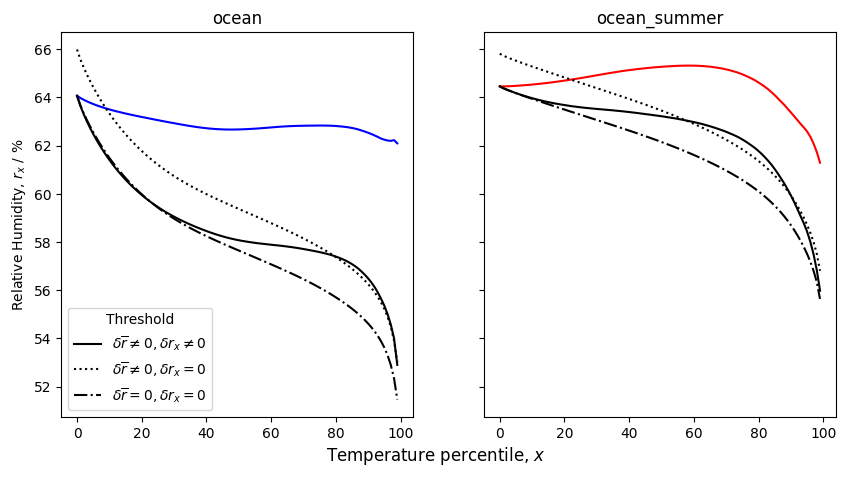

In [34]:
def thresh_rh(temp_bar, rh_bar, temp_x, delta_rh_bar=0, delta_rh_x=0):
    # bar means mean and x means percentile.
    # returns threshold relative humidity, below which get temp increase greater than mean
    return clausius_clapeyron_factor(temp_bar) * sphum_sat(temp_bar, p_surface) * (rh_bar + delta_rh_bar) / \
        (clausius_clapeyron_factor(temp_x) * sphum_sat(temp_x, p_surface)) - delta_rh_x

# Use relavent surface as mean
thresh_rh_all = {surf: [thresh_rh(temp_mean[surf][0], rh_mean[surf][0], temp_quant[surf][0],
                       rh_mean[surf][1] - rh_mean[surf][0], rh_quant[surf][1] - rh_quant[surf][0]),
                        thresh_rh(temp_mean[surf][0], rh_mean[surf][0], temp_quant[surf][0],
                       rh_mean[surf][1] - rh_mean[surf][0]),
                        thresh_rh(temp_mean[surf][0], rh_mean[surf][0], temp_quant[surf][0])] for surf in surfaces}


fig, ax = plt.subplots(1,n_surf, figsize=(10, 5), sharex=True, sharey=True)
for k, surf in enumerate(surfaces):
    ax[k].plot(quant_plot, 100*rh_quant[surf][0], color=plt_color[surf])
    ax[k].plot(quant_plot, 100*thresh_rh_all[surf][0], linestyle='-', color='k', label='$\delta \overline{r} \\neq 0, \delta r_x \\neq 0$')
    ax[k].plot(quant_plot, 100*thresh_rh_all[surf][1], linestyle=':', color='k', label='$\delta \overline{r} \\neq 0, \delta r_x = 0$')
    ax[k].plot(quant_plot, 100*thresh_rh_all[surf][2], linestyle='-.', color='k', label='$\delta \overline{r} = 0, \delta r_x = 0$')
    ax[k].set_title(surf)
ax[0].legend(title='Threshold')
ax[0].set_ylabel('Relative Humidity, $r_x$ / %')
fig.supxlabel('Temperature percentile, $x$');

## $\epsilon$ Analysis

In [35]:
e_quant = {surf: [mse[surf][i]-mse_ft_sat[surf][i] for i in range(n_exp)] for surf in surfaces}

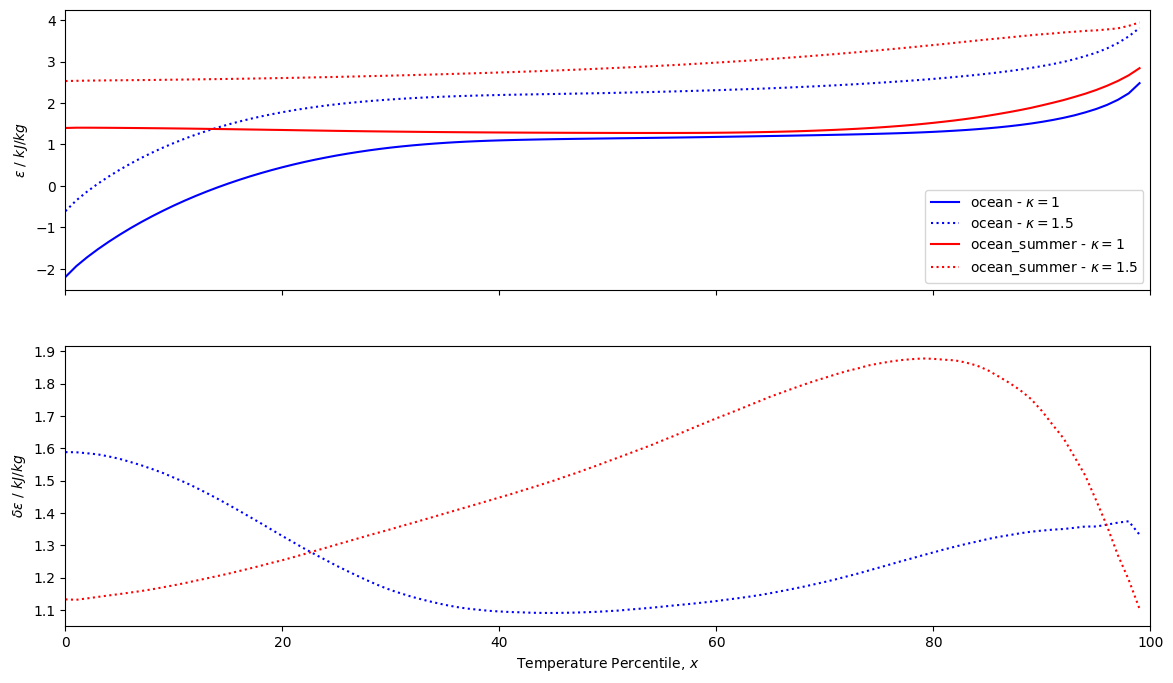

In [36]:
fig, ax = plt.subplots(2,1, figsize=(14, 8), sharex=True)
for surf in surfaces:
    ax[0].plot(quant_plot, e_quant[surf][0], color=plt_color[surf], label=f'{surf} - $\kappa={tau_lw_ref}$')
    ax[0].plot(quant_plot, e_quant[surf][1], color=plt_color[surf], linestyle=':', label=f'{surf} - $\kappa={tau_lw_warm}$')

    ax[1].plot(quant_plot, e_quant[surf][1] - e_quant[surf][0], color=plt_color[surf],
               linestyle=':', label=f'{surf} - $\kappa={tau_lw_warm}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel(f'$\epsilon$ / $kJ/kg$')
ax[1].set_ylabel(f'$\delta \epsilon$ / $kJ/kg$')
ax[0].legend()
ax[0].set_xlim(0,100);

## Exact breakdown of MSE
The exact equation for surface MSE is:
$$h_x = \overline{h} + \Delta h_{x,FT}^* + \epsilon_x - \overline{\epsilon}$$
The breakdown of this and the changes are shown below

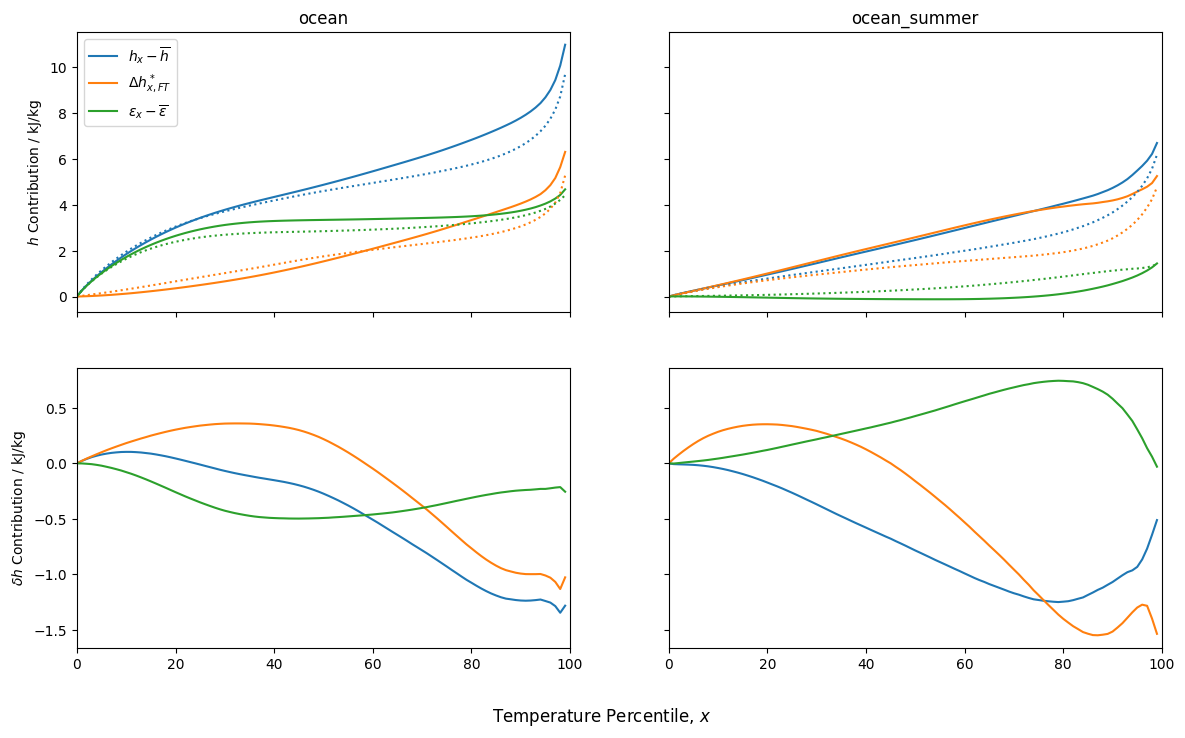

In [41]:
fig, ax = plt.subplots(2,n_surf, figsize=(14, 8), sharex=True, sharey='row')
for k, surf in enumerate(surfaces):
    for i in range(n_exp):
        if i == 0:
            labels = ['$h_x - \overline{h}$', '$\Delta h_{x,FT}^*$', '$\epsilon_x - \overline{\epsilon}$']
            linestyle = '-'
        else:
            labels = [None, None, None, None]
            linestyle = ':'
        ax[0, k].plot(quant_plot, mse[surf][i] - mse[surf][i][0], label=labels[0],
                   color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linestyle=linestyle)
        ax[0, k].plot(quant_plot, mse_ft_sat[surf][i]-mse_ft_sat[surf][i][0], label=labels[1],
                   color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], linestyle=linestyle)
        ax[0, k].plot(quant_plot, e_quant[surf][i] -e_quant[surf][i][0], label=labels[2],
                   color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], linestyle=linestyle)
    ax[1, k].plot(quant_plot, (mse[surf][1] - mse[surf][1][0]) - (mse[surf][0] - mse[surf][0][0]),
               color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    ax[1, k].plot(quant_plot, (mse_ft_sat[surf][1]-mse_ft_sat[surf][1][0]) - (mse_ft_sat['ocean'][0]-mse_ft_sat['ocean'][0][0]),
               color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    ax[1, k].plot(quant_plot, (e_quant[surf][1] -e_quant[surf][1][0]) - (e_quant[surf][0] -e_quant[surf][0][0]),
               color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
    ax[0, k].set_title(surf)
ax[0, 0].legend()
ax[0, 0].set_ylabel('$h$ Contribution / kJ/kg')
ax[1, 0].set_ylabel('$\delta h$ Contribution / kJ/kg')
fig.supxlabel('Temperature Percentile, $x$')
ax[0, 0].set_xlim(0,100);

Below is the same plot as above, but decomposing into temperature changes rather than MSE changes. Hence, an additional specific humidity, $q$ term is introduced.

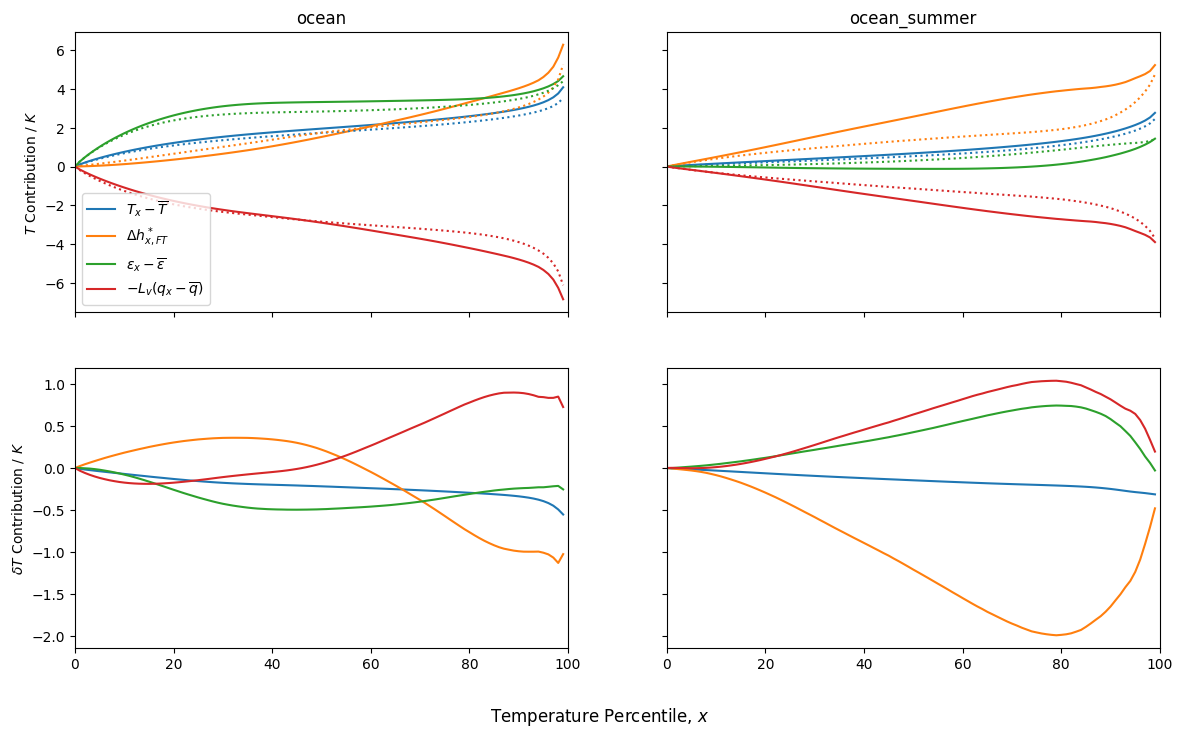

In [44]:
fig, ax = plt.subplots(2,n_surf, figsize=(14, 8), sharex=True, sharey='row')
for k, surf in enumerate(surfaces):
    for i in range(n_exp):
        if i == 0:
            labels = ['$T_x - \overline{T}$', '$\Delta h_{x,FT}^*$', '$\epsilon_x - \overline{\epsilon}$', '$-L_v(q_x - \overline{q})$']
            linestyle = '-'
        else:
            labels = [None, None, None, None]
            linestyle = ':'
        ax[0, k].plot(quant_plot, temp_quant[surf][i] - temp_quant[surf][i][0], label=labels[0],
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linestyle=linestyle)
        ax[0, k].plot(quant_plot, 1000/c_p*(mse_ft_sat[surf][i]-mse_ft_sat[surf][i][0]), label=labels[1],
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], linestyle=linestyle)
        ax[0, k].plot(quant_plot, 1000/c_p*(e_quant[surf][i] -e_quant[surf][i][0]), label=labels[2],
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], linestyle=linestyle)
        ax[0, k].plot(quant_plot, -L_v/c_p * (sphum_quant[surf][i] -sphum_quant[surf][i][0]), label=labels[3],
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linestyle=linestyle)
    ax[1, k].plot(quant_plot, (temp_quant[surf][1] - temp_quant[surf][1][0]) - (temp_quant[surf][0] - temp_quant[surf][0][0]),
                  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    ax[1, k].plot(quant_plot, 1000/c_p * ((mse_ft_sat[surf][1]-mse_ft_sat[surf][1][0]) -
                                          (mse_ft_sat[surf][0]-mse_ft_sat[surf][0][0])),
                  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    ax[1, k].plot(quant_plot, 1000/c_p*((e_quant[surf][1] -e_quant[surf][1][0]) -
                                        (e_quant[surf][0] -e_quant[surf][0][0])),
                  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
    ax[1, k].plot(quant_plot, -L_v/c_p*((sphum_quant[surf][1] -sphum_quant[surf][1][0]) -
                                        (sphum_quant[surf][0] -sphum_quant[surf][0][0])),
                  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
    ax[0, k].set_title(surf)
ax[0, 0].legend()
ax[0, 0].set_ylabel('$T$ Contribution / $K$')
ax[1, 0].set_ylabel('$\delta T$ Contribution / $K$')
fig.supxlabel('Temperature Percentile, $x$')
ax[0, 0].set_xlim(0,100);

From the above plot, there seems to be a clear relationship between the change in the free troposphere MSE difference, $\delta \Delta h_{x,FT}^*$ and the change in the surface specific humidity difference, $\delta \Delta q_x$.

The $\delta \Delta q_x$ has contributions from changes in relative humidity and changes in temperature, as well as a non linear term, as shown below.

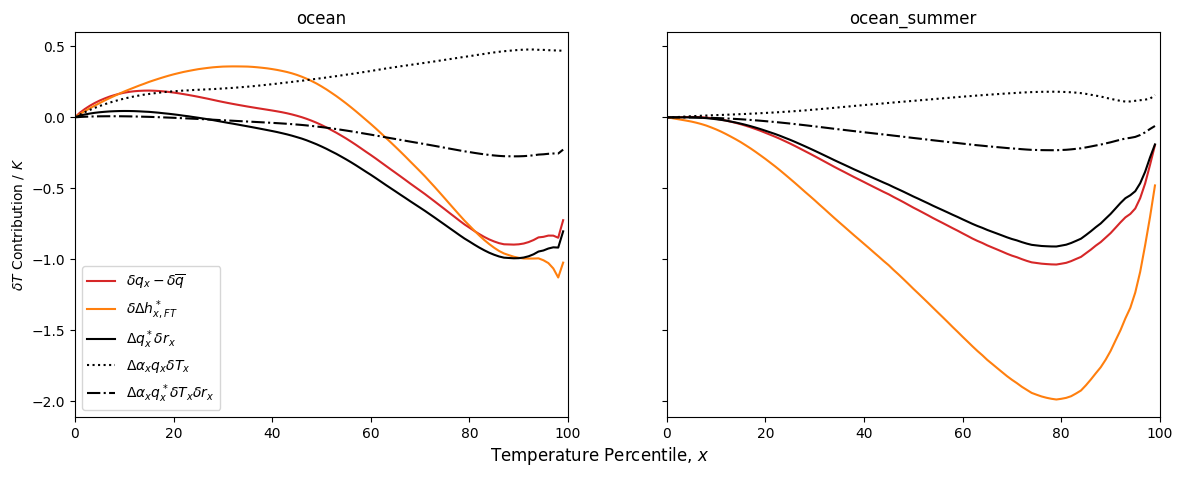

In [45]:
fig, ax = plt.subplots(1,n_surf, figsize=(14, 5), sharex=True, sharey=True)
for k, surf in enumerate(surfaces):
    sphum_change_terms_x = [L_v/c_p*sphum_sat(temp_quant[surf][0], p_surface) * (rh_quant[surf][1]-rh_quant[surf][0]),
                            L_v/c_p*clausius_clapeyron_factor(temp_quant[surf][0])*sphum_quant[surf][0]*
                            (temp_quant[surf][1]-temp_quant[surf][0]),
                            L_v/c_p*clausius_clapeyron_factor(temp_quant[surf][0])*sphum_sat(temp_quant[surf][0], p_surface)*
                            (temp_quant[surf][1]-temp_quant[surf][0])*(rh_quant[surf][1]-rh_quant[surf][0])]

    ax[k].plot(quant_plot, L_v/c_p*((sphum_quant[surf][1] -sphum_quant[surf][1][0]) -
                                    (sphum_quant[surf][0] -sphum_quant[surf][0][0])),
               color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], label='$\delta q_x - \delta \overline{q}$')
    ax[k].plot(quant_plot, 1000/c_p * ((mse_ft_sat[surf][1]-mse_ft_sat[surf][1][0]) -
                                       (mse_ft_sat[surf][0]-mse_ft_sat[surf][0][0])),
               color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], label='$\delta \Delta h_{x,FT}^*$')
    ax[k].plot(quant_plot, sphum_change_terms_x[0]-sphum_change_terms_x[0][0], color='k', linestyle='-',
               label='$\Delta q_x^*\delta r_x$')
    ax[k].plot(quant_plot, sphum_change_terms_x[1]-sphum_change_terms_x[1][0], color='k', linestyle=':',
               label='$\Delta \\alpha_xq_x\delta T_x$')
    ax[k].plot(quant_plot, sphum_change_terms_x[2]-sphum_change_terms_x[2][0], color='k', linestyle='-.',
               label='$\Delta \\alpha_xq^*_x\delta T_x \delta r_x$')
    ax[k].set_title(surf)
ax[0].set_ylabel('$\delta T$ Contribution / $K$')
fig.supxlabel('Temperature Percentile, $x$')
ax[0].legend()
ax[0].set_xlim(0,100);

The plot below shows that there is a clear relationship between the surface specific humidity and the free troposphere temperature, with this relationship changing as we warm the climate.

From this, we should be able to predict the free troposphere temperature based on the surface specific humidity. Then the free troposphere saturated MSE only depends on this free troposphere temperature, so we should be able to relate the $\Delta h_{x,FT}^*$ term above to the $q$ term.

## Ocean to Ocean median changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3. Thought maybe can use this to get theory related x percentile temperatures to average.

In [46]:
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
# mse as function of mse quantile not temp quantile
mse_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
# rh as function of rh quantile not temp quantile
rh_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}

for i in range(n_exp):
        for k, ds_use in enumerate([ds_all['ocean'], ds_summer]):
            temp_quant2[surfaces[k]][i] = ds_use[i].temp[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
            sphum_quant2[surfaces[k]][i] = ds_use[i].sphum[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
            mse_use = moist_static_energy(ds_use[i].temp[-1], ds_use[i].sphum[-1], ds_use[i].height[-1])
            mse_quant2[surfaces[k]][i] = mse_use.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
            rh_use = rh_from_sphum(ds_use[i].sphum[-1], ds_use[i].temp[-1], p_surface)
            rh_quant2[surfaces[k]][i] = rh_use.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)

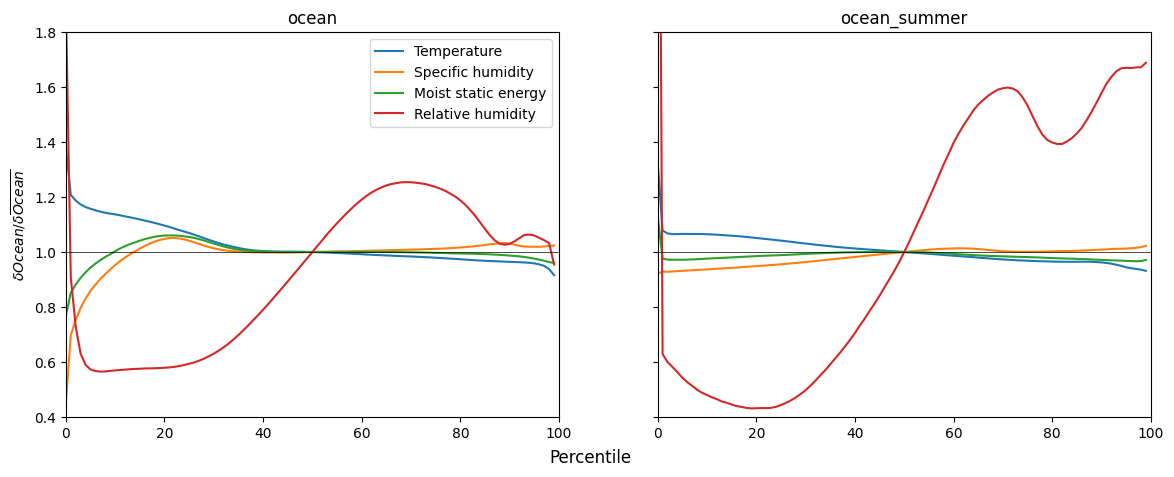

In [53]:
fig, ax = plt.subplots(1,n_surf, figsize=(14, 5), sharex=True, sharey=True)
labels = ['Temperature', 'Specific humidity', 'Moist static energy', 'Relative humidity']
av_ind = np.where(quant_plot==50)[0]
for k, surf in enumerate(surfaces):
    for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2, rh_quant2]):
        ax[k].plot(quant_plot, (var[surf][1]-var[surf][0])/(var[surf][1][av_ind]-var[surf][0][av_ind]), label=labels[i])
    ax[k].hlines(1,0,100, color='k', linewidth=0.5)
    ax[k].set_title(surf)
ax[0].legend()
fig.supxlabel('Percentile')
ax[0].set_ylabel('$\delta Ocean/\delta \overline{Ocean}$')
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0.4,1.8);

## Entrainment Theory

Entrainment of air with a saturation deficit of $(1 - RH)q^*$ is what causes the free troposphere MSE to be less than the surface value. The zero buoyancy plume model gives a theory for this deficit:

$$\epsilon = h_{surface} - h^*_{FT} = \int_{z_0}^{z_{FT}} \frac{\hat{\epsilon}}{z} L_v (1-RH)q^* dz$$

Where $\hat{\epsilon}$ is a constant that needs tuning, but typically it is around 0.5. $z_0$ is the altitude of the cloud base, which is taken to be the altitude of the LCL.

An example of this theoretical value of $\epsilon$ is shown below for a single temperature quantile, $x$.

In [200]:
# Load in one dataset averaged over given single temperature quantile.
# See how MSE surplus for this single quantile compares to the predicted value
quant_entrain = 0
ds_entrain = {'ocean': [], 'ocean_summer': []}          # Contains all data
ds_entrain_quant = {'ocean': [], 'ocean_summer': []}    # Mean over given quantile
with tqdm(total=n_exp * n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
        ds_use = ds_use.sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))    # NH summer is JAS
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is JFM
        # Combine hemispheres and average over longitude, time and latitude.
        # Note that April, May, June, October, November and December will not be included in this dataset
        ds_use_summer = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use_summer = ds_use_summer.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        ds_entrain['ocean_summer'] += [ds_use_summer]
        ds_entrain['ocean_summer'][i].load()
        quantile_thresh = ds_entrain['ocean_summer'][i].temp[-1].quantile(quant_entrain/100, dim='lon_lat_time', keep_attrs=True)
        ds_entrain_quant['ocean_summer'] += [ds_entrain['ocean_summer'][i].where(
            ds_entrain['ocean_summer'][i].temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)]
        pbar.update(1)
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        ds_entrain['ocean'] += [ds_use]
        ds_entrain['ocean'][i].load()
        quantile_thresh = ds_entrain['ocean'][i].temp[-1].quantile(quant_entrain/100, dim='lon_lat_time', keep_attrs=True)
        ds_entrain_quant['ocean'] += [ds_entrain['ocean'][i].where(
            ds_entrain['ocean'][i].temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)]
        pbar.update(1)

100%|██████████| 4/4 [00:42<00:00, 10.60s/it]


In [206]:
n_p = ds_entrain['ocean'][0].pfull.size
mse_entrain = {'ocean': np.zeros(n_exp), 'ocean_summer': np.zeros(n_exp)}
mse_entrain_sat = {'ocean': np.zeros((n_exp, n_p)), 'ocean_summer': np.zeros((n_exp, n_p))}
for k, surf in enumerate(surfaces):
    for i in range(n_exp):
        mse_entrain[surf][i] = mse[surf][i][np.where(quant_plot==quant_entrain)[0]]
        # Need sat mse for all pressure levels hence can't use previous mse
        mse_entrain_sat[surf][i] = moist_static_energy(ds_entrain_quant[surf][i].temp, sphum_sat(ds_entrain_quant[surf][i].temp,
                                                                                           ds_entrain_quant[surf][i].pfull * 100),
                                                       ds_entrain_quant[surf][i].height)

In [240]:
def lcl_pressure(dataset):
    # Return pressure in hPa
    temp_lcl = lcl_temp(dataset.temp[-1], dataset.pfull[-1]*100, dataset.sphum[-1])
    p_lcl = dataset.pfull[-1] * (temp_lcl/dataset.temp[-1])**(1/kappa)      # Pressure corresponding to LCL from dry adiabat equation
    return p_lcl

def get_mse_deficit(dataset, p_lcl, p_upper=None, rh=None, epsilon_hat=0.75):
    """
    Returns model value of mse deficit at each height/pressure value in dataset in kJ/kg.
    First value refers to the p_lcl and is 0.

    This does not assume that relative humidity is constant in the free troposphere, but uses the actual values
    based on the specific humidity and temperature.

    Args:
        dataset:
        p_lcl: lifting condensation pressure in hPa
        p_upper: Upper level in atmsophere where you want to integrate to.
            If None, will compute for each pressure level.
        rh: relative humidity, leave as None to use actual relative humidity, or specify
            a constant value e.g. 0.8.
        epsilon_hat:

    Returns:

    """
    # Formula is only valid above the lifting condensation level or cloud base so first find that and get rid of p values below it
    # Ensure include LCL pressure in the plot by finding nearest pressure value in dataset that is near it
    if isinstance(p_lcl, xr.DataArray):
        near_ind = np.argmin(np.abs(dataset.pfull.to_numpy() - p_lcl.to_numpy()))
    else:
        near_ind = np.argmin(np.abs(dataset.pfull.to_numpy() - p_lcl))
    if dataset.pfull[near_ind] < p_lcl:
        # Ensure pressure level found is above the LCL
        near_ind += 1
    try:
        p_lcl = float(dataset.pfull[near_ind])
    except IndexError:
        p_lcl = float(dataset.pfull[near_ind-1])
    small = 1       # small shift to p_lcl so ensure that pressure level included
    if p_upper is None:
        dataset = dataset.sel(pfull=slice(0, p_lcl+small))
    else:
        dataset = dataset.sel(pfull=slice(p_upper-small, p_lcl+small))
    # [::-1] so first value is at surface
    q_sat = np.asarray(sphum_sat(dataset.temp, dataset.pfull * 100))[::-1]
    if rh is None:
        rh = dataset.sphum[::-1] / q_sat
    height = np.asarray(dataset.height)[::-1]
    epsilon = epsilon_hat / height      # use form of epsilon suggested in paper
    integrand = L_v * epsilon * q_sat * (1-rh)
    if p_upper is None:
        integral = np.asarray([integrate.simpson(integrand[:i], height[:i]) for i in range(1, height.size+1)])
        return integral / 1000, dataset.pfull[::-1]
    else:
        integral = integrate.simpson(integrand, height) # just return a single value from p_lcl to p_upper
        return float(integral / 1000), float(dataset.pfull[0])


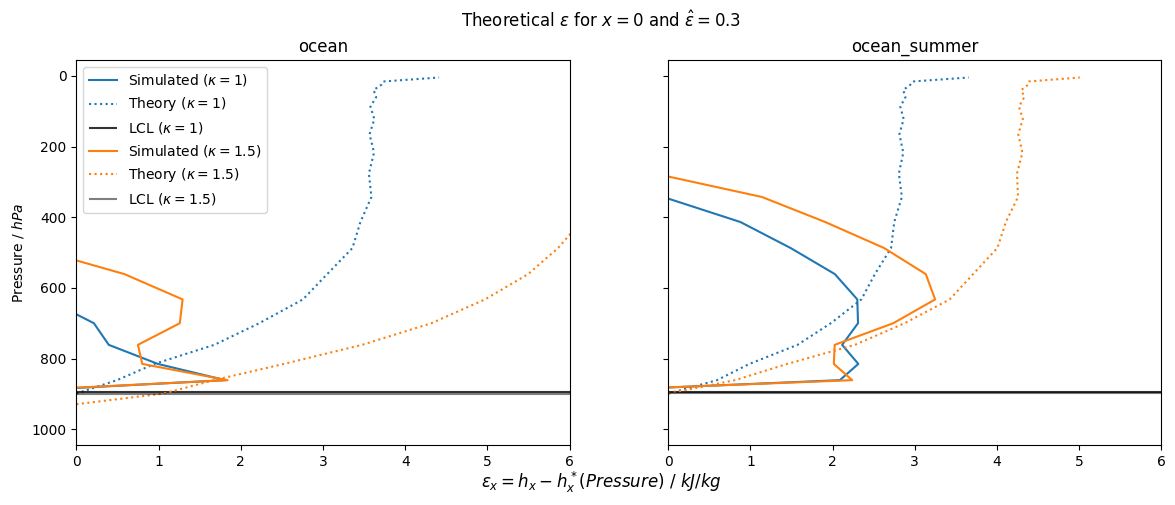

In [405]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
epsilon_hat1 = 0.3
fig, ax = plt.subplots(1,n_surf, figsize=(14, 5), sharex=True, sharey=True)
for k, surf in enumerate(surfaces):
    for i in range(n_exp):
        ax[k].plot(mse_entrain[surf][i]-mse_entrain_sat[surf][i], ds_entrain_quant[surf][i].pfull, color=default_colors[i],
                   label=f'Simulated ($\kappa={tau_lw[i]}$)')
        sim_mse_def = get_mse_deficit(ds_entrain_quant[surf][i], lcl_pressure(ds_entrain_quant[surf][i]), rh=None, epsilon_hat=0.3)
        ax[k].plot(sim_mse_def[0], sim_mse_def[1], color=default_colors[i], linestyle=':',
                   label=f'Theory ($\kappa={tau_lw[i]}$)')
        ax[k].hlines(lcl_pressure(ds_entrain_quant[surf][i]), -20, 20, colors='k', label=f'LCL ($\kappa={tau_lw[i]}$)', alpha=0.8-i*0.3)
    ax[k].set_title(surf)
ax[0].set_ylabel('Pressure / $hPa$')
fig.supxlabel('$\epsilon_x = h_x - h_x^*(Pressure)$ / $kJ/kg$')
ax[0].set_xlim(0, 6)
ax[0].invert_yaxis()
ax[0].legend()
fig.suptitle(f'Theoretical $\epsilon$ for $x={quant_entrain}$ and '+'$\hat{\epsilon}='+f'{epsilon_hat1}$');

We can see that this captures the general trend for increasing $\epsilon$ with $\kappa$ but does not do well at predicting $\epsilon$ at low pressures. It also does a better job with the `ocean_summer` data set, as might be expected since we always have ascending air parcels in this data set.

### Theory 5
Next, we see if we can use this theory for $\epsilon$ to improve on Theory 4. Allowing for variation in $\epsilon$, the new Theory 5 is:
$$ \delta h_x = \delta \overline{h} + \delta \Delta h_{x, FT} + \delta (\epsilon_x - \overline{\epsilon})$$


In [301]:
p_lcl = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}
mse_def_theory = {'ocean': np.zeros((n_exp, n_quant)), 'ocean_summer': np.zeros((n_exp, n_quant))}

with tqdm(total=n_exp*n_quant*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            for k, surf in enumerate(surfaces):
                ds_use = ds_entrain[surf][i]
                quantile_thresh = ds_use.temp[-1].quantile(quant/100, dim='lon_lat_time', keep_attrs=True)
                ds_use = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)

                p_lcl[surfaces[k]][i, j] = lcl_pressure(ds_use)
                # Use actual relative humidity (makes quite a bit of difference) and add epsilon hat stuff
                # after computation so use epsilon_hat=1
                mse_def_theory[surf][i, j] = get_mse_deficit(ds_use, p_lcl=p_lcl[surfaces[k]][i, j], p_upper=pressure_ft_actual/100,
                                                             rh=None, epsilon_hat=1)[0]
                pbar.update(1)

100%|██████████| 400/400 [05:19<00:00,  1.25it/s]


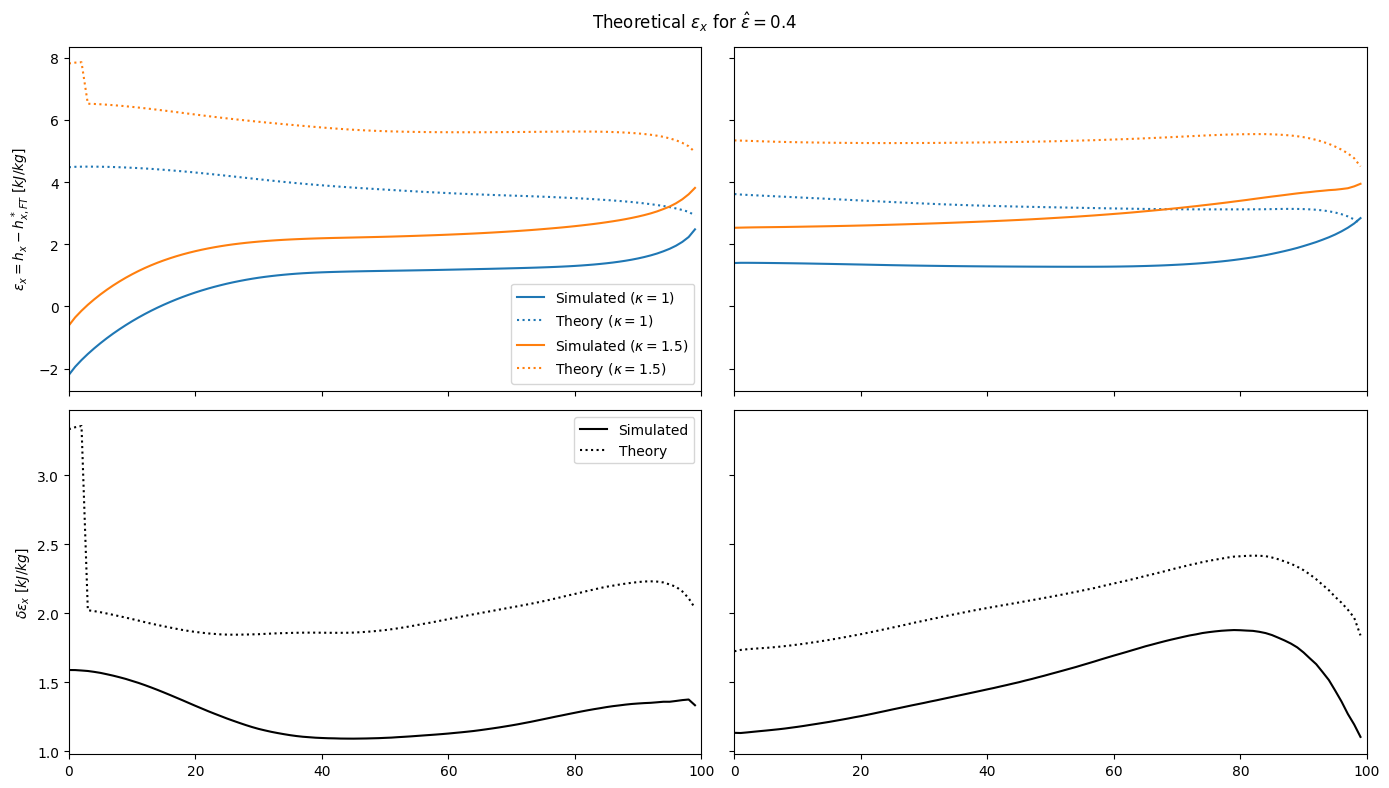

In [412]:
epsilon_hat2 = 0.4
delta_epsilon_theory = {'ocean': None, 'ocean_summer': None}
fig, ax = plt.subplots(2,n_surf, figsize=(14, 8), sharex=True, sharey='row')
for k, surf in enumerate(surfaces):
    delta_epsilon_theory[surf] = (mse_def_theory[surf][1] - mse_def_theory[surf][0]) * epsilon_hat2
    for i in range(n_exp):
        ax[0, k].plot(quant_plot, e_quant[surf][i], color=default_colors[i],
                      label=f'Simulated ($\kappa = {tau_lw[i]}$)')
        ax[0, k].plot(quant_plot, mse_def_theory[surf][i] * epsilon_hat2, color=default_colors[i],
                      linestyle=':', label=f'Theory ($\kappa = {tau_lw[i]}$)')
    ax[1, k].plot(quant_plot, e_quant[surf][1]-e_quant[surf][0], color='k',
                  label='Simulated')
    ax[1, k].plot(quant_plot, delta_epsilon_theory[surf], color='k',
                  linestyle=':', label='Theory')
ax[0, 0].set_ylabel('$\epsilon_x = h_x - h_{x, FT}^*$ $[kJ/kg]$')
ax[1, 0].set_ylabel('$\delta \epsilon_x$ $[kJ/kg]$')
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_xlim(0,100)
fig.suptitle('Theoretical $\epsilon_x$ for $\hat{\epsilon}='+f'{epsilon_hat2}$')
plt.tight_layout();

The plot above shows that the individual $\epsilon_x$ values and trends are not captured very well by the theory. However, the trend in the change in $\epsilon_x$ with warming, $\delta \epsilon_x$ is captured well by the theory.

However, for the Theory 5 prediction for $\delta T_x$, we are interested in $\delta (\epsilon_x - \overline{\epsilon})$. We see below, that with the `ocean_summer` dataset, we can predict this very well with $\hat{\epsilon} = 0.4$.

Note that the above plot looks better with $\hat{\epsilon} = 0.3$ but the plot below looks worse.

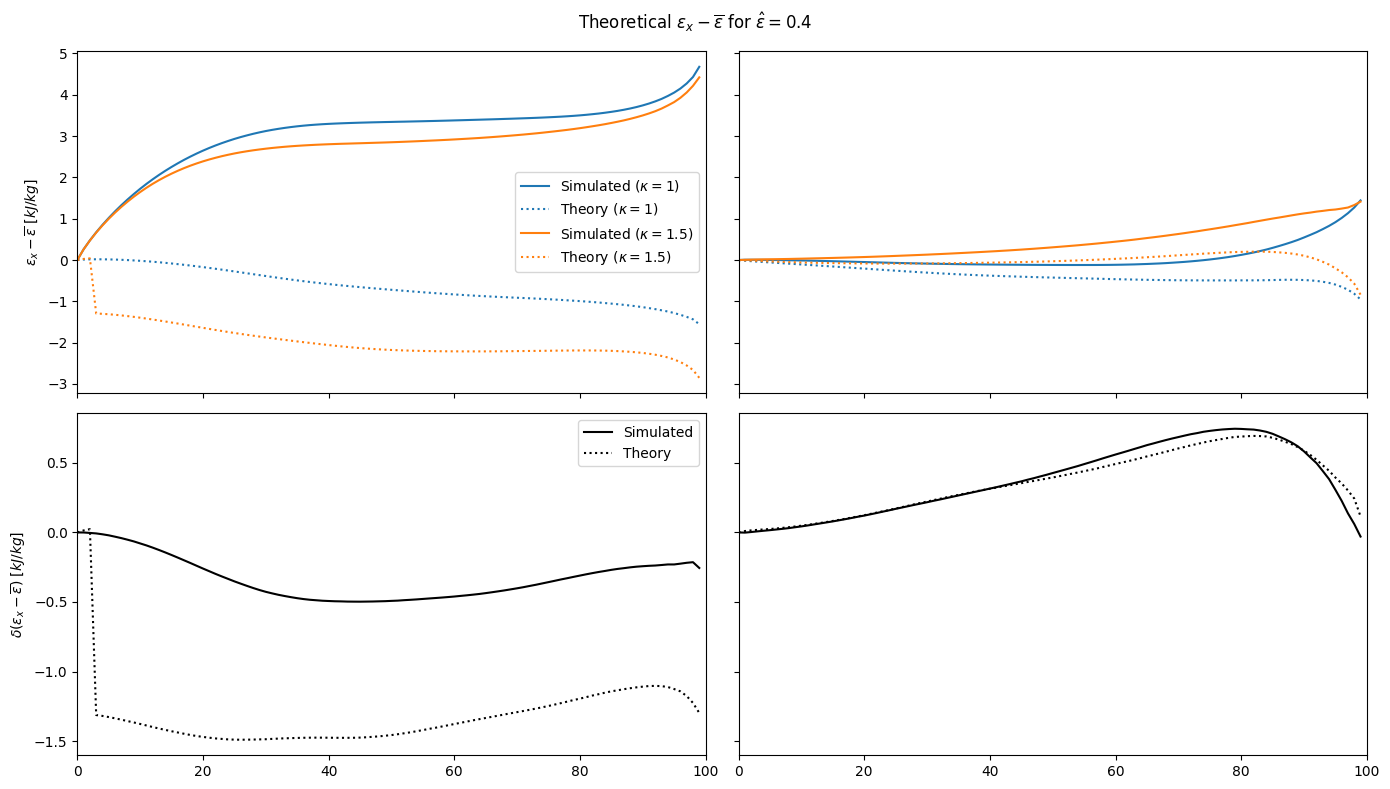

In [413]:
fig, ax = plt.subplots(2,n_surf, figsize=(14, 8), sharex=True, sharey='row')
for k, surf in enumerate(surfaces):
    for i in range(n_exp):
        ax[0, k].plot(quant_plot, e_quant[surf][i] - e_quant[surf][i][0], color=default_colors[i],
                      label=f'Simulated ($\kappa = {tau_lw[i]}$)')
        ax[0, k].plot(quant_plot, (mse_def_theory[surf][i] - mse_def_theory[surf][i][0]) * epsilon_hat2, color=default_colors[i],
                      linestyle=':', label=f'Theory ($\kappa = {tau_lw[i]}$)')
    ax[1, k].plot(quant_plot, (e_quant[surf][1]-e_quant[surf][1][0])-(e_quant[surf][0]-e_quant[surf][0][0]), color='k',
                  label='Simulated')
    ax[1, k].plot(quant_plot, delta_epsilon_theory[surf] - delta_epsilon_theory[surf][0], color='k',
                  linestyle=':', label='Theory')
ax[0, 0].set_ylabel('$\epsilon_x - \overline{\epsilon}$ $[kJ/kg]$')
ax[1, 0].set_ylabel('$\delta (\epsilon_x - \overline{\epsilon})$ $[kJ/kg]$')
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_xlim(0,100)
fig.suptitle('Theoretical $\epsilon_x - \overline{\epsilon}$ for $\hat{\epsilon}='+f'{epsilon_hat2}$')
plt.tight_layout();

Theory 5 shown below includes the theoretical $\delta (\epsilon_x - \overline{\epsilon})$ term in the above plot. This clearly shows an improvement on Theory 4. However, to obtain it, it requires knowledge of the temperature at every level of the atmosphere in both the reference and warmer simulation. The value of $\hat{\epsilon}$ also seems a little arbitrary.

The `ocean` plot is not included below as it clearly doesn't look great in the above plot.

In [396]:
for surf in surfaces:
    if temp_theory_cont[surf].shape[0] == 4:
        # Pad axis with zeros
        temp_theory_cont[surf] = np.pad(temp_theory_cont[surf], ((0,1), (0,0)))
    temp_theory_cont[surf][4] = (delta_epsilon_theory[surf] - delta_epsilon_theory[surf][0]) * gamma[surf][4] * 1000

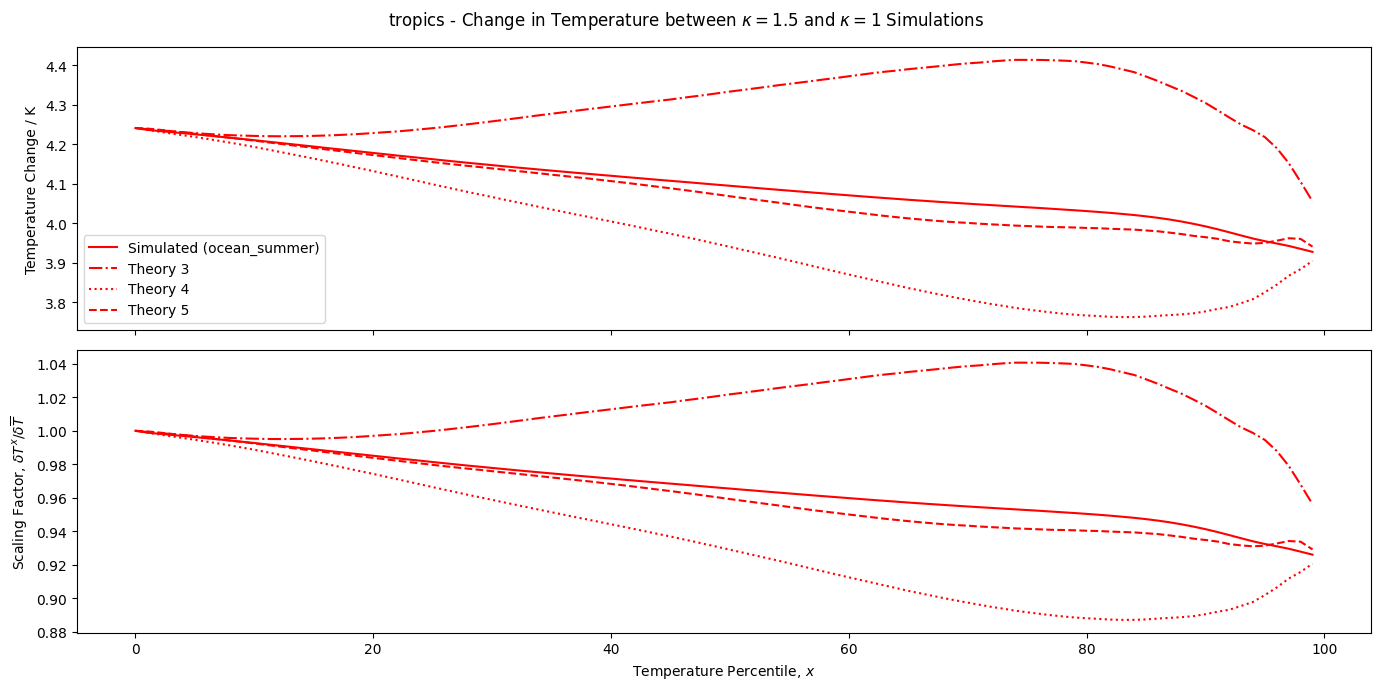

In [397]:
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True)
for surf in ['ocean_summer']:
    temp_diff_quant = temp_quant[surf][1]-temp_quant[surf][0]
    temp_diff_mean = temp_mean[surf][1]-temp_mean[surf][0]
    ax[0].plot(quant_plot, temp_diff_quant, label=f'Simulated ({surf})', color=plt_color[surf])
    if surf == 'ocean_summer':
        label1 = 'Theory 3'
        label2 = 'Theory 4'
        label3 = 'Theory 5'
    else:
        label1 = None
        label2 = None
        label3 = None
    ax[0].plot(quant_plot, np.sum(temp_theory_cont[surf][:3], axis=0), label=label1, color=plt_color[surf], linestyle='-.')
    ax[0].plot(quant_plot, np.sum(temp_theory_cont[surf][:4], axis=0), label=label2, color=plt_color[surf], linestyle=':')
    ax[0].plot(quant_plot, np.sum(temp_theory_cont[surf][:5], axis=0), label=label3, color=plt_color[surf], linestyle='--')
    ax[1].plot(quant_plot, temp_diff_quant/temp_diff_mean, label=surf, color=plt_color[surf])
    ax[1].plot(quant_plot, np.sum(temp_theory_cont[surf][:3], axis=0)/np.sum(temp_theory_cont[surf][:3], axis=0)[0],
               label=surf, color=plt_color[surf], linestyle='-.')
    ax[1].plot(quant_plot, np.sum(temp_theory_cont[surf][:4], axis=0)/np.sum(temp_theory_cont[surf][:4], axis=0)[0],
               label=surf, color=plt_color[surf], linestyle=':')
    ax[1].plot(quant_plot, np.sum(temp_theory_cont[surf][:5], axis=0)/np.sum(temp_theory_cont[surf][:5], axis=0)[0],
           label=surf, color=plt_color[surf], linestyle='--')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations")
plt.tight_layout();